## HOUSE DATA PRICE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jucyharo import *

from scipy import stats
import statsmodels.api as sm
from scipy.stats import norm

from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, lasso_path, LassoCV

## Chargement des données

In [ ]:
train = pd.read_csv('data/train.csv',index_col="Id")
test = pd.read_csv('data/test.csv',index_col="Id")

Paramètres de visualisation pour jupyter

In [ ]:
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 100

## Concaténation des données

### Concatenation du dataset pour faciliter le traitement

In [ ]:
# sauvegarde du nombre de ligne du train et du test
n_train = train.shape[0]
n_test = test.shape[0]
# mettre le SalePrice le target dans une variable a part
target = train.SalePrice

# suppression de la colonne SalePrice
train.drop(['SalePrice'], axis=1, inplace=True)

#concatenation des data train et test
df_inter = pd.concat((train, test)).reset_index(drop=True)

## Gestion des données manquantes
Visualisation des données manquantes

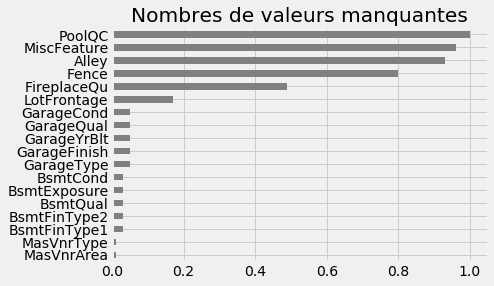

In [70]:
view_total_na(df_inter)

In [51]:
# total_na = round((df_inter.isna().sum().sort_values())/df_inter.shape[0], 2)
# col_miss_values = (total_na[total_na > 0]).index
# total_na[col_miss_values].plot(kind='barh',color='grey',figsize=(8,5),title="Nombres de valeurs manquantes")

On décide de supprimer les colonnes contenant plus de 15% de valeurs manquantes

In [71]:
total_na = round((df_inter.isna().sum().sort_values())/df_inter.shape[0], 2)
cols_low_na = total_na[total_na < 0.15]
df_inter = df_inter[cols_low_na.index]

## Gestion des valeurs manquantes

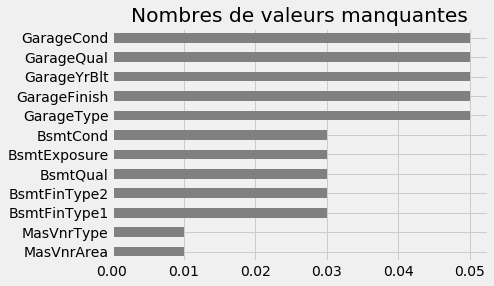

In [72]:
view_total_na(df_inter)

On décide de remplacer les n/a qualitatifs par un label "N/A"

In [52]:
# cols_low_na = total_na[total_na < 0.15]
# df_inter = df_inter[cols_low_na.index]

## Gestion des valeurs manquantes

In [53]:
# total_na = df_inter.isna().sum().sort_values()
# total_na[total_na > 0].plot(kind='barh',color='grey',figsize=(8,5),title="Nombre de valeurs manquantes")

In [54]:
# Dans les colonnes à plus de 20% de NA, ont décide de remplacer les np.nan, par des NA string, ce qui pourrais nous 
# permettre de créer une nouvelle classe, s'il y a un eventuelle, on decide donc de les garder au lieu de les supprimer
cols_replace_na_cat = ["GarageType","GarageFinish","GarageQual","GarageCond",'BsmtQual','BsmtCond',
                       'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']

for i in cols_replace_na_cat:
    df_inter[i].fillna('N/A', inplace=True)

In [55]:
# Nous decidons de remplacer les NA par des 0, plustôt que par la moyenne ou la mediane pour éviter de biaiser les 
# données. on peut peut pas utiliser la moyenne à cause des outliers et en utilisant la médiane on risque d'attriber
# des valeurs à des caractéristiques de maison qui n'existe pas.
cols_replace_na_num =['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath',
                      'GarageYrBlt','GarageArea','GarageCars','MasVnrArea']

for i in cols_replace_na_num:
    df_inter[i].fillna(0, inplace=True)

In [56]:
# Les variables listée ci-dessous possèdent un nombre de NA comprit entre 1 et 4, on decide donc de remplacer ces valeurs manquantes par la
# classe modale qui revient le plus.
cols_replace_na_cat1 = ['MSZoning','Utilities','Functional', 'SaleType','KitchenQual','Exterior2nd','Exterior1st','Electrical']

for i in cols_replace_na_cat1:
    df_inter[i].fillna(df_inter[i].mode()[0], inplace=True)

In [57]:
# j'ai préféré grouper par Neighborhood pour tenir compte de comment sont les lotFrontage de la ville
df_inter['LotFrontage'] = df_inter.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [73]:
cols_replace_na_cat = ["GarageCond","GarageType","GarageFinish","GarageQual"]
df_inter[cols_replace_na_cat] = df_inter[cols_replace_na_cat].fillna('N/A')

On remplace les valeurs quantitatifs par des 0, car la référence concernée n'existe pas

In [74]:
cols_replace_na_num =['GarageCars','GarageYrBlt','MasVnrArea','GarageArea','BsmtFinSF1','TotalBsmtSF']
df_inter[cols_replace_na_num] = df_inter[cols_replace_na_num].fillna(0)

## Création de features

Varirable quantitative -> Création d'une variable binaire si haute fréquence de zéro

### Variable TotalBsmtSF
variable binaire extraite -> HasBsmt 


In [75]:
df_inter['HasBsmt'] = df_inter['TotalBsmtSF'] > 0
#view_correlations(df_inter,'TotalBsmtSF')

Tentons de remplacer 0 de TotalBsmt par une regression sur 1stFlrSF

Préparation de 1stFlrSF pour la prediction de basement

0.7874144527364718

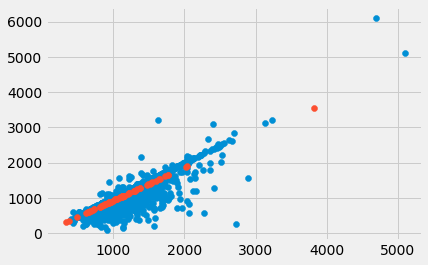

In [76]:
#plt.scatter(x='1stFlrSF',y='TotalBsmtSF',data=df_inter)
train_bsmt = df_inter[['1stFlrSF','TotalBsmtSF','HasBsmt']]
lm = LinearRegression()
X_train = df_inter[df_inter['HasBsmt'] == 1][['1stFlrSF']]
X_test = df_inter[df_inter['HasBsmt'] == 0][['1stFlrSF']]
Y_train = df_inter[df_inter['HasBsmt'] == 1]['TotalBsmtSF']

lm.fit(X_train,Y_train)
predicts = lm.predict(X_test)
plt.scatter(x=X_train['1stFlrSF'],y=Y_train)
plt.scatter(x=X_test['1stFlrSF'],y=predicts)
lm.score(X_train,Y_train)

Utilisation des predictions pour remplacer les valeurs manquantes du sous-sol

In [77]:
"""df_inter.loc[df_inter['HasBsmt'] == 0,'TotalBsmtSF'] = predicts"""

"df_inter.loc[df_inter['HasBsmt'] == 0,'TotalBsmtSF'] = predicts"

In [78]:
"""cols_quant = []
for col in df_inter.columns:
    if df_inter[col].dtype in [np.int64,np.float64]:
        cols_quant.append(col)
        
view_distributions(df_inter[cols_quant])"""

'cols_quant = []\nfor col in df_inter.columns:\n    if df_inter[col].dtype in [np.int64,np.float64]:\n        cols_quant.append(col)\n        \nview_distributions(df_inter[cols_quant])'

## Transform Feature

## Reconstitution de la data

In [91]:
## Cette méthode permet d'éviter les erreurs en cas de lignes supprimées
# Les index doivent correspondres à l'id des ventes (voir le chargement de données)
# Ne peux pas être viable si une réinitisalisation des index est efféctuée

is_index_train = df_inter.index.isin(train.index)
is_index_test = df_inter.index.isin(test.index)

# reconstitution test nettoyé
test_clean = df_inter[is_index_test]

# reconstitution train nettoyé + prix
train_clean = df_inter[is_index_train]                     
train_clean = pd.merge(train_clean, y_train.to_frame(), left_index=True, right_index=True)

In [58]:
<<<<<<< LOCAL CELL DELETED >>>>>>>
train_clean = df_inter[:n_train]
test_clean = df_inter[n_train:]
train_clean = pd.concat((train_clean, target), axis=1).reset_index(drop=True)
train_clean.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Séléction de features
Visualisations des corrélations

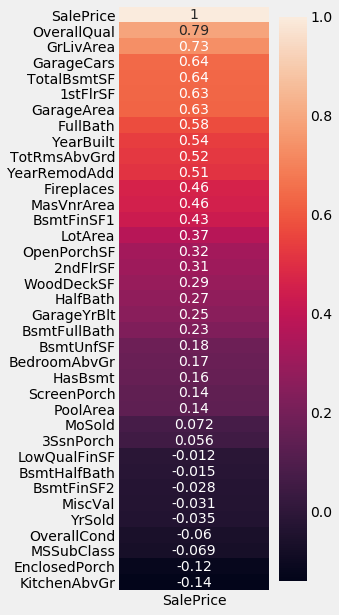

In [93]:
view_one_correlation(train_clean,'SalePrice',figsize=(3,10))

On garde les variables quantitatives corrélées à plus de 25%

In [ ]:
corr_price = train_clean.corr()['SalePrice']
<<<<<<< local
cols_features = corr_price[corr_price > 0.25].index
=======
cols_features = corr_price[corr_price > 0.25].index
# train_clean = train_clean[cols_features]
>>>>>>> remote

On retire les variables explicatives corrélées entre elles.

In [117]:
cols_duplicates = ['1stFlrSF','2ndFlrSF','GarageArea']
cols_features = cols_features.drop(cols_duplicates)

In [118]:
# Mise à jour des jeux de données
train_clean = train_clean[cols_features]
test_clean = test_clean[cols_features.drop('SalePrice')]

In [119]:
view_total_na(train_clean)

'Aucune données manquantes :)'

## Création de features

### Autre methode de selection

Prendre toutes les variables corréllés à plus de 0%.

Les faire tourner avec une méthode de selection de variable tel que le stepwise, mais en choisissant les variables sur le critère de L'AIC. c'est à dire en minimisant l'AIC. on choissira l'ensemble des variables qui minimise l'AIC. 
Après application de cette méthode on obtient les variables ci-dessous.

In [62]:
# X correspond au dataframe du train
# df_test correspond au dataframe du test

X = train_clean[["OverallQual","GrLivArea","BsmtFinSF1","GarageCars","MSSubClass","BedroomAbvGr","MasVnrArea","WoodDeckSF",
"LotArea","BsmtFullBath","FullBath","OverallCond","TotalBsmtSF","TotRmsAbvGrd","KitchenAbvGr","ScreenPorch",
"HalfBath","EnclosedPorch","LowQualFinSF",'CentralAir','Electrical','HeatingQC','Neighborhood','ExterQual']]

df_test = test_clean[["OverallQual","GrLivArea","BsmtFinSF1","GarageCars","MSSubClass","BedroomAbvGr","MasVnrArea","WoodDeckSF",
"LotArea","BsmtFullBath","FullBath","OverallCond","TotalBsmtSF","TotRmsAbvGrd","KitchenAbvGr","ScreenPorch",
"HalfBath","EnclosedPorch","LowQualFinSF",'CentralAir','Electrical','HeatingQC','Neighborhood','ExterQual']]

### Get dummies

In [63]:
# on garde dans une variable le shape des dataframes X et df_test pour pouvoir les resplit après
n_X = train.shape[0]
n_df_test = test.shape[0]

# On concatène ensuite les dataframes X et df_test pour faire le get_dummies sur l'ensemble 
df_concat = pd.concat((X, df_test)).reset_index(drop=True)

# le dummies sur le df_concat
df_with_dummies = pd.get_dummies(df_concat)

### Resplit du df_with_dummies en X et df_test

In [64]:
X = df_with_dummies[:n_X]
df_test = df_with_dummies[n_X:]

Visualisations des corrélations

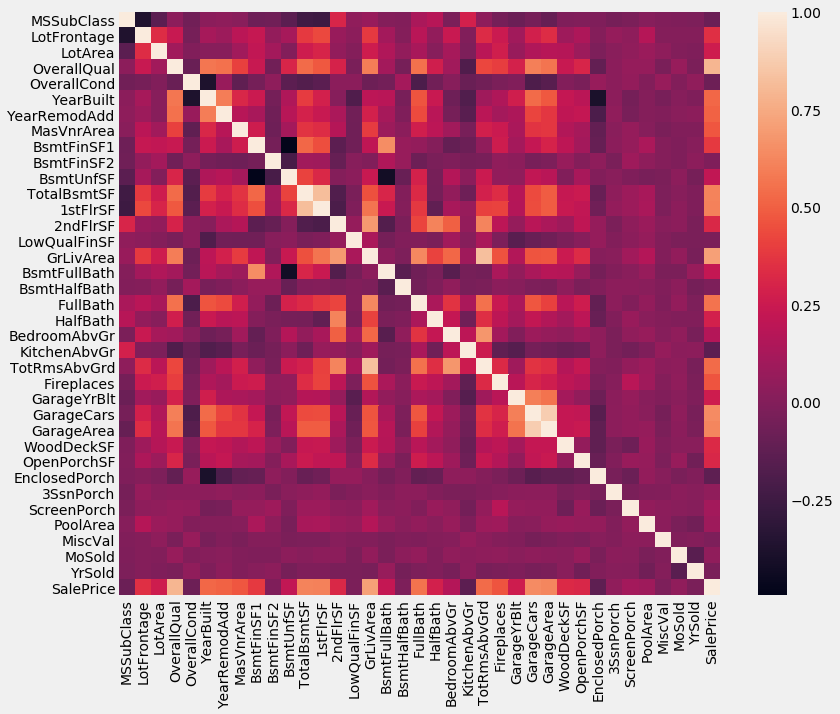

In [65]:
plt.figure(figsize=(12,10))
sns.heatmap(train_clean.corr())

On garde les variables quantitatives corrélées à plus de 25%

In [67]:
corr_price = train_clean.corr()['SalePrice']
cols_features = corr_price[corr_price > 0.25].index
train_clean = train_clean[cols_features]
train_clean.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,7,2003,2003,196.0,706.0,856.0,856,854,1710,2,1,8,0,2003.0,2.0,548.0,0,61,208500
1,80.0,9600,6,1976,1976,0.0,978.0,1262.0,1262,0,1262,2,0,6,1,1976.0,2.0,460.0,298,0,181500
2,68.0,11250,7,2001,2002,162.0,486.0,920.0,920,866,1786,2,1,6,1,2001.0,2.0,608.0,0,42,223500
3,60.0,9550,7,1915,1970,0.0,216.0,756.0,961,756,1717,1,0,7,1,1998.0,3.0,642.0,0,35,140000
4,84.0,14260,8,2000,2000,350.0,655.0,1145.0,1145,1053,2198,2,1,9,1,2000.0,3.0,836.0,192,84,250000


In [68]:
train_clean.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'SalePrice'],
      dtype='object')

In [69]:
#Suppresion des colonnes 1rstFloor, 2ndFloor,GarageArea,
train_clean=train_clean.drop(['1stFlrSF', '2ndFlrSF','GarageArea','GarageYrBlt'],axis=1)
train_clean


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,7,2003,2003,196.0,706.0,856.0,1710,2,1,8,0,2.0,0,61,208500
1,80.0,9600,6,1976,1976,0.0,978.0,1262.0,1262,2,0,6,1,2.0,298,0,181500
2,68.0,11250,7,2001,2002,162.0,486.0,920.0,1786,2,1,6,1,2.0,0,42,223500
3,60.0,9550,7,1915,1970,0.0,216.0,756.0,1717,1,0,7,1,3.0,0,35,140000
4,84.0,14260,8,2000,2000,350.0,655.0,1145.0,2198,2,1,9,1,3.0,192,84,250000
5,85.0,14115,5,1993,1995,0.0,732.0,796.0,1362,1,1,5,0,2.0,40,30,143000
6,75.0,10084,8,2004,2005,186.0,1369.0,1686.0,1694,2,0,7,1,2.0,255,57,307000
7,80.0,10382,7,1973,1973,240.0,859.0,1107.0,2090,2,1,7,2,2.0,235,204,200000
8,51.0,6120,7,1931,1950,0.0,0.0,952.0,1774,2,0,8,2,2.0,90,0,129900
9,50.0,7420,5,1939,1950,0.0,851.0,991.0,1077,1,0,5,2,1.0,0,4,118000


In [70]:
train_clean.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'FullBath',
       'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'SalePrice'],
      dtype='object')

In [71]:
train_clean.dtypes

LotFrontage     float64
LotArea           int64
OverallQual       int64
YearBuilt         int64
YearRemodAdd      int64
MasVnrArea      float64
BsmtFinSF1      float64
TotalBsmtSF     float64
GrLivArea         int64
FullBath          int64
HalfBath          int64
TotRmsAbvGrd      int64
Fireplaces        int64
GarageCars      float64
WoodDeckSF        int64
OpenPorchSF       int64
SalePrice         int64
dtype: object

In [72]:
train_clean['YearBuilt'].unique()

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905], dtype=int64)

In [73]:
#Transformation des colonnes 'YearBuilt','YearRemodAdd'
train_clean['YearBuilt'] = train_clean['YearBuilt'].apply(str)
train_clean['YearRemodAdd'] = train_clean['YearRemodAdd'].apply(str)
train_clean.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,7,2003,2003,196.0,706.0,856.0,1710,2,1,8,0,2.0,0,61,208500
1,80.0,9600,6,1976,1976,0.0,978.0,1262.0,1262,2,0,6,1,2.0,298,0,181500
2,68.0,11250,7,2001,2002,162.0,486.0,920.0,1786,2,1,6,1,2.0,0,42,223500
3,60.0,9550,7,1915,1970,0.0,216.0,756.0,1717,1,0,7,1,3.0,0,35,140000
4,84.0,14260,8,2000,2000,350.0,655.0,1145.0,2198,2,1,9,1,3.0,192,84,250000


In [74]:
#Transformation des float  en int
train_clean['GarageCars'] = train_clean['GarageCars'].apply(int)
train_clean['TotalBsmtSF'] = train_clean['TotalBsmtSF'].apply(int)
train_clean['BsmtFinSF1'] = train_clean['BsmtFinSF1'].apply(int)
train_clean['MasVnrArea'] = train_clean['MasVnrArea'].apply(int)


In [75]:
#Transformation en catégorial

label_encoder = LabelEncoder()
train_clean['YearBuilt'] = label_encoder.fit_transform(train_clean['YearBuilt'])
train_clean['YearRemodAdd']=label_encoder.fit_transform(train_clean['YearRemodAdd'])
train_clean


,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.0,8450,7,104,53,196,706,856,1710,2,1,8,0,2,0,61,208500
1,80.0,9600,6,77,26,0,978,1262,1262,2,0,6,1,2,298,0,181500
2,68.0,11250,7,102,52,162,486,920,1786,2,1,6,1,2,0,42,223500
3,60.0,9550,7,19,20,0,216,756,1717,1,0,7,1,3,0,35,140000
4,84.0,14260,8,101,50,350,655,1145,2198,2,1,9,1,3,192,84,250000
5,85.0,14115,5,94,45,0,732,796,1362,1,1,5,0,2,40,30,143000
6,75.0,10084,8,105,55,186,1369,1686,1694,2,0,7,1,2,255,57,307000
7,80.0,10382,7,74,23,240,859,1107,2090,2,1,7,2,2,235,204,200000
8,51.0,6120,7,35,0,0,0,952,1774,2,0,8,2,2,90,0,129900
9,50.0,7420,5,42,0,0,851,991,1077,1,0,5,2,1,0,4,118000


## Gestion des outliers

In [120]:
train_clean.drop(1299, inplace=True)

KeyError: '[1299] not found in axis'

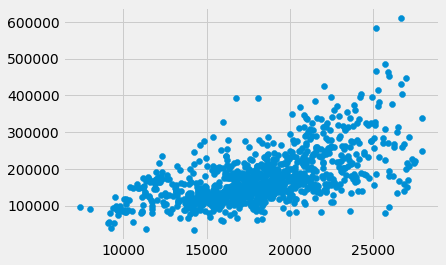

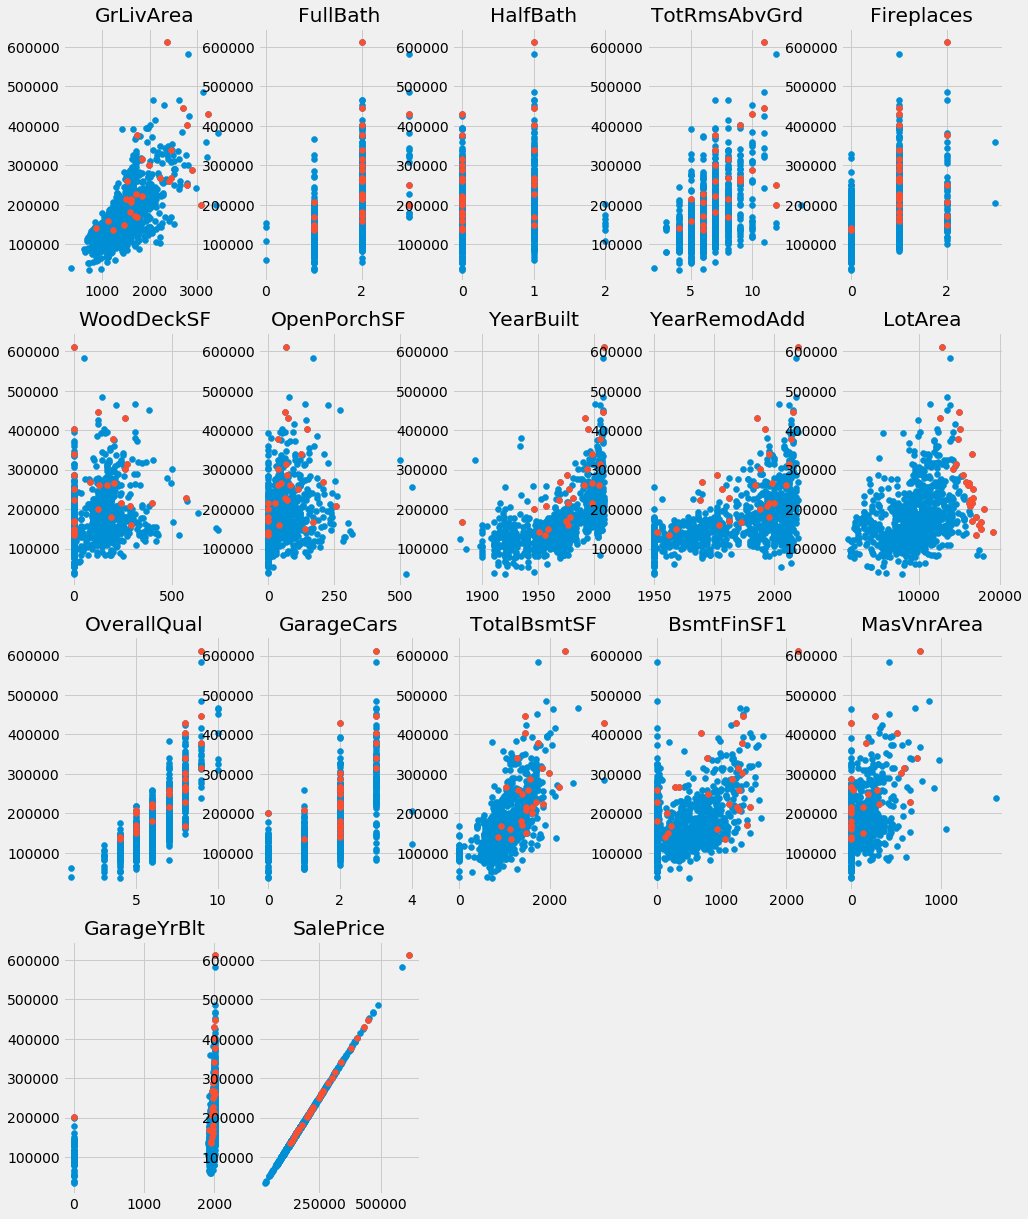

In [121]:
total = train_clean.drop('SalePrice',axis=1).aggregate("sum",axis=1)
plt.scatter(total,train_clean['SalePrice'])
outliers = total[total > np.mean(total) + (2*np.std(total))].index

view_correlations(train_clean,'SalePrice',outliers=list(outliers))
## poid de la branche sur toute la regression
#plt.scatter(train_clean[train_clean.index.isin(outliers)]['LotArea'],train_clean[train_clean.index.isin(outliers)]['LotArea'])

Les outliers désignés ne devraient pas avoir d'impact négatif sur notre régression

In [122]:
train_clean.drop(outliers,inplace=True)

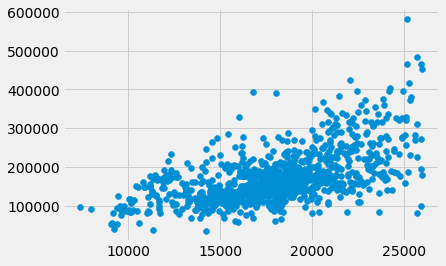

In [126]:
total = train_clean.drop(['SalePrice'],axis=1).aggregate("sum",axis=1)
plt.scatter(total,train_clean['SalePrice'])

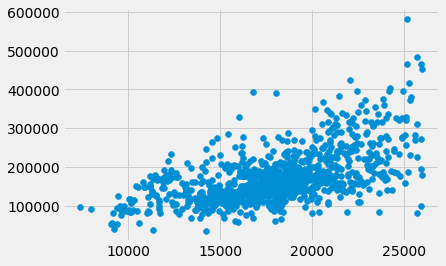

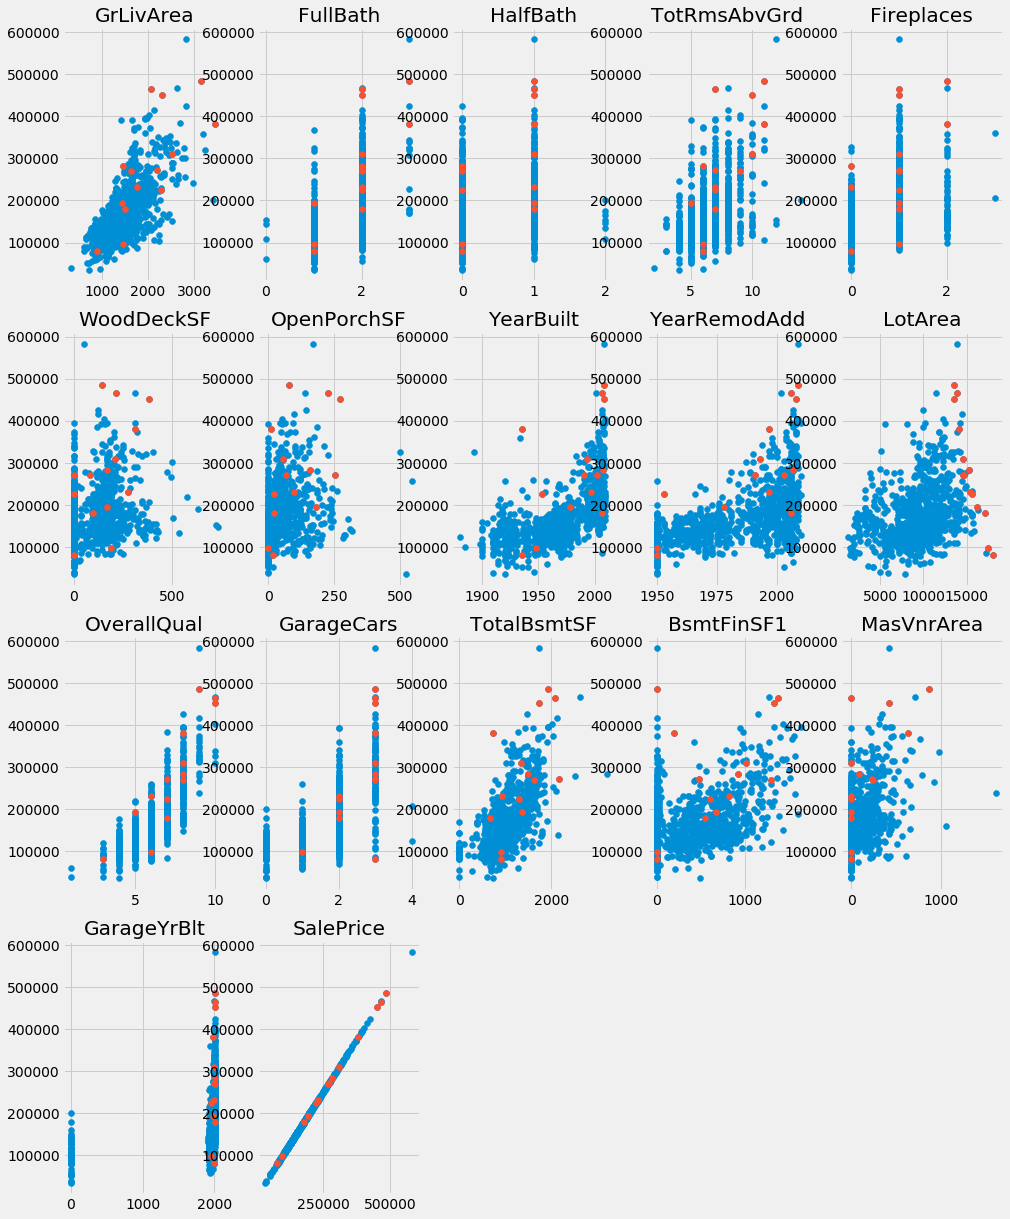

In [125]:
outliers = total[total > np.mean(total) + (2*np.std(total))].index
view_correlations(train_clean,'SalePrice',outliers=list(outliers))

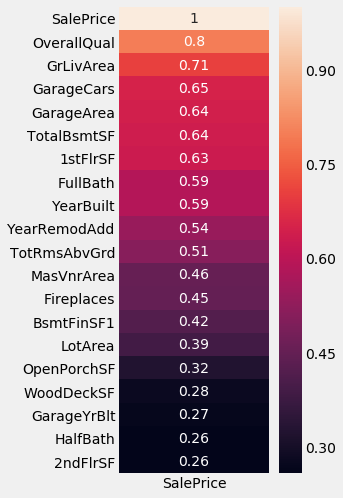

In [115]:
view_one_correlation(train_clean,'SalePrice',figsize=(3,8))

## Modèle d'apprentissage
- Définir un seuil final pour le test_size

### Normalisation de X et y
Par une échèlle logarithmique

In [76]:
# normalisation de X
X = np.log(X+1)

# Le target la variable à prédire
y = target
# normalisation de y
y = np.log(y+1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# Entrainement du model
model_house = linear_model.LinearRegression()
model_house.fit(X_train, y_train)

# prediction sur le test pour tester le model
y_pred = model_house.predict(X_test)

# Metrics
print('Mean Squared Error : {}\n'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Error : {}\n'.format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('coefficient de determination : {}\n'.format(r2_score(y_test, y_pred)))

Mean Squared Error : 4.2604161848896075e+20

Root Mean Squared Error : 20640775627.11636

coefficient de determination : -2.5893218105206217e+21



## Prédiction sur le test

### Normalisation du df_test
Par une échèlle logarithmique

In [78]:
#test_clean = test_clean[cols_features.drop('SalePrice')]

In [79]:
df_test = np.log(df_test+1)

pred_test = model_house.predict(df_test)

### Dénormalisation de la prediction

Pour obtenir les valeurs à la bonne échèlle

In [80]:
pred_test = np.exp(pred_test)

### Soumission sur Kaggle

In [81]:
#pred_test = np.exp(pred_test)

pred = pd.DataFrame(test_id)

pred['SalePrice']=pred_test

In [82]:
#pred

In [83]:
pred.to_csv('house_prediction_kaggle', index=False, encoding='utf-8')

## Resultat Kaggle

In [84]:
#<img src="C:/Users/Administrateur/Pictures/Screenshots/Capture d’écran (1).png">

# Regression Lasso

Pour que la regression lassoCV soit optimal il est néccessaire que les données soient normalisée c'est à dire centrée et réduites

In [85]:
# LcvX correspond au dataframe du train
# Lcvdf_test correspond au dataframe du test

LcvX = df_with_dummies[:n_X]
Lcvdf_test = df_with_dummies[n_X:]

In [86]:
# on concatène les données du train et de le target afin de les normaliser en même temps
LcvX = pd.concat((LcvX, target), axis=1).reset_index(drop=True)

### Normalisation

In [87]:
sc_train = StandardScaler()

LcvX_norm = sc_train.fit_transform(LcvX)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Construction du model

In [88]:
model_house_lcv = LassoCV(normalize=False,fit_intercept=False,random_state=0,cv=5)

# lancement sur l'échantillon d'apprentissage
# -1 parceque le SalePrice se trouve à la fin
model_house_lcv.fit(LcvX_norm[:,:-1],LcvX_norm[:,-1])

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=0, selection='cyclic',
    tol=0.0001, verbose=False)

## Application du modèle sur le test

### Normalisation du test

In [89]:
sc_test = StandardScaler()
Lcvdf_test_norm =  sc_test.fit_transform(Lcvdf_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [90]:
# Prediction avec le modèle
pred_Lcv_norm = model_house_lcv.predict(Lcvdf_test_norm)

In [91]:
# dénormalisation de la prédiction, [-1] parce que y est en dernière position
pred_Lcv = pred_Lcv_norm*np.sqrt(sc_train.var_[-1]) + sc_train.mean_[-1]

## Soumission Kaggle

In [92]:
pred = pd.DataFrame(test_id)

pred['SalePrice']=pred_Lcv

pred.to_csv('first_house_prediction', index=False, encoding='utf-8')

In [93]:
pred

,Id,SalePrice
0,1461,123826.479181
1,1462,166865.724737
2,1463,172437.764134
3,1464,195976.127885
4,1465,242068.269002
5,1466,175414.468102
6,1467,199008.026558
7,1468,161973.677535
8,1469,191144.279078
9,1470,119240.055771


In [ ]:
Y = train_clean['SalePrice']
X = train_clean.drop(['SalePrice'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=100)
lm = LinearRegression()
lm.fit(X_train,y_train)
lm.predict(X_test)
lm.score(X_test,y_test)

<<<<<<< local


0.822284105727543

0.8101412290249742

>>>>>>> remote


## Prédictions  sur le test

In [106]:
view_total_na(test_clean)

'Aucune données manquantes :)'

In [107]:

pred_test = lm.predict(test_clean)
predictions = pd.DataFrame({'Id':test_clean.index,'SalePrice': pred_test}) 
predictions.to_csv('submission', index=False, encoding='utf-8')

In [108]:
predictions

,Id,SalePrice
0,1461,112890.375333
1,1462,174473.281659
2,1463,191346.904887
3,1464,190788.937848
4,1465,195104.176321
5,1466,169933.311889
6,1467,177754.918474
7,1468,156329.562342
8,1469,208830.118976
9,1470,111018.890854
